# Agentic Adaptive RAG with LangGraph

In this notebook, we'll build the most sophisticated RAG system yet - one that adapts its strategy based on query complexity, evaluates result quality, and can even rewrite queries for better results.

## What is Adaptive RAG?

Adaptive RAG goes beyond simple routing by:
1. **Analyzing query complexity** to determine the best retrieval strategy
2. **Searching multiple collections** when queries span domains
3. **Evaluating result quality** and adapting if results are poor
4. **Rewriting queries** to improve retrieval when needed
5. **Self-correcting** through iterative refinement

## Learning Objectives

By the end of this notebook, you will:
- Understand query complexity analysis and strategy selection
- Build multi-collection search capabilities
- Implement response quality evaluation and grading
- Create query rewriting and expansion mechanisms
- Design self-correcting RAG workflows
- Compare adaptive RAG with simpler approaches

## Setup and Imports

We'll need additional imports for the adaptive functionality.

In [1]:
import os
from pathlib import Path
from typing import List, TypedDict, Literal, Optional

from dotenv import load_dotenv
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.retrievers import TavilySearchAPIRetriever
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field
from IPython.display import Image, display

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


## Environment Setup

In [2]:
# Check if OpenAI API key is available
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY environment variable is required")

# Check if Tavily API key is available
tavily_api_key = os.getenv("TAVILY_API_KEY")
if not tavily_api_key:
    raise ValueError("TAVILY_API_KEY environment variable is required for web search functionality")

print("OpenAI API key found!")
print("Tavily API key found!")

OpenAI API key found!
Tavily API key found!


## Connect to ChromaDB Collections

We'll use the same separate collections as in the router RAG notebook.

In [3]:
# Initialize embeddings model
embeddings = OpenAIEmbeddings(
    model=os.getenv("OPENAI_EMBEDDING_MODEL", "text-embedding-3-small"),
    api_key=openai_api_key
)

# Path to the separate ChromaDB collections
chroma_db_path = Path("..") / "vector_store" / "chroma_db_separate"

# Connect to each collection
catalog_store = Chroma(
    collection_name="techmart_catalog",
    embedding_function=embeddings,
    persist_directory=str(chroma_db_path)
)

faq_store = Chroma(
    collection_name="techmart_faq",
    embedding_function=embeddings,
    persist_directory=str(chroma_db_path)
)

troubleshooting_store = Chroma(
    collection_name="techmart_troubleshooting",
    embedding_function=embeddings,
    persist_directory=str(chroma_db_path)
)

# Create a mapping for easy access
collections = {
    "catalog": catalog_store,
    "faq": faq_store,
    "troubleshooting": troubleshooting_store
}

print(f"Connected to ChromaDB collections at: {chroma_db_path}")
for name, store in collections.items():
    print(f"{name}: {store._collection.count()} documents")

Connected to ChromaDB collections at: ../vector_store/chroma_db_separate
catalog: 325 documents
faq: 50 documents
troubleshooting: 154 documents


## Initialize Language Models

In [4]:
# Initialize separate language models for different tasks
# Analysis LLM - Most capable model for complex query analysis and decomposition
analysis_llm = ChatOpenAI(
    model="gpt-4.1",
    api_key=openai_api_key,
)

# Generation LLM - Balanced model for answer generation
generation_llm = ChatOpenAI(
    model="gpt-4.1-mini",
    api_key=openai_api_key,
)

# Evaluation LLM - Fast model for document relevance evaluation
evaluation_llm = ChatOpenAI(
    model="gpt-4.1-nano",
    api_key=openai_api_key,
)

print(f"Analysis language model initialized: {analysis_llm.model_name}")
print(f"Generation language model initialized: {generation_llm.model_name}")
print(f"Evaluation language model initialized: {evaluation_llm.model_name}")

Analysis language model initialized: gpt-4.1
Generation language model initialized: gpt-4.1-mini
Evaluation language model initialized: gpt-4.1-nano


## Define Adaptive RAG State

Our state needs to track the entire adaptive workflow including strategy decisions, multiple retrievals, and quality assessments.

In [5]:
class AdaptiveRAGState(TypedDict):
    """State for our Adaptive RAG workflow."""
    # Input
    query: str
    original_query: str
    
    # Query decomposition
    needs_decomposition: bool
    sub_queries: List[str]
    execution_plan: str  # "sequential" or "parallel"
    current_sub_query_index: int
    sub_query_results: List[dict]  # Results from each sub-query
    
    # Strategy and routing
    search_strategy: str
    collections_to_search: List[str]
    
    # Retrieval results
    retrieved_docs: List[Document]
    all_retrieved_docs: dict  # Store docs by collection
    
    # Quality assessment
    docs_relevant: bool
    quality_score: float
    
    # Query rewriting
    needs_rewrite: bool
    rewritten_query: Optional[str]
    retry_count: int
    
    # Output
    answer: str
    confidence: str

print("Adaptive RAG state defined!")

Adaptive RAG state defined!


## Query Analysis

The first step is analyzing the query to determine the best retrieval strategy.

In [6]:
class QueryAnalysis(BaseModel):
    """Analysis of query characteristics."""
    needs_decomposition: bool = Field(
        description="Whether the query should be broken down into sub-queries"
    )
    sub_queries: List[str] = Field(
        description="List of sub-queries if decomposition is needed",
        default_factory=list
    )
    execution_plan: Literal["sequential", "parallel"] = Field(
        description="How sub-queries should be executed",
        default="parallel"
    )
    search_strategy: Literal["single_collection", "multi_collection", "comprehensive"] = Field(
        description="Recommended search strategy"
    )
    collections_needed: List[Literal["catalog", "faq", "troubleshooting", "web_search"]] = Field(
        description="Collections that should be searched"
    )
    reasoning: str = Field(
        description="Explanation of the analysis and strategy choice"
    )

# Query analysis prompt
analysis_prompt = ChatPromptTemplate.from_template(
    """You are a query analyzer for TechMart's adaptive RAG system.
Analyze the query to determine whether it needs decomposition, and the best retrieval strategy.

Available collections:
- **catalog**: Product information, specifications, recommendations
- **faq**: Customer service, shipping, returns, policies
- **troubleshooting**: Technical support, problem diagnosis, solutions for TechMart products
- **web_search**: For troubleshooting questions about issues not covered in our internal troubleshooting database, or for getting the latest information about software, drivers, or technical problems that require current information from the internet

Query decomposition rules:
- **Decompose if**: Query contains multiple distinct questions, has complex AND/OR logic, or spans multiple unrelated domains
- **Don't decompose if**: Query is cohesive even if complex, or sub-parts heavily depend on each other

Execution plans:
- **sequential**: When later sub-queries depend on earlier results (e.g., "Find gaming laptops, then tell me about warranty for the best one")
- **parallel**: When sub-queries are independent (e.g., "What gaming laptops do you have and what are your shipping options?")

Search strategies:
- **single_collection**: Search one most relevant collection
- **multi_collection**: Search 2-3 relevant collections
- **comprehensive**: Search all collections for complex/vague queries

Collection selection rules:
- Use **web_search** for troubleshooting issues that are likely not covered in our limited internal database
- Use **web_search** for current software, driver, or OS compatibility issues
- Use internal collections (catalog, faq, troubleshooting) for TechMart-specific information

Examples:
1. "What gaming laptops do you have and what are your return policies?" 
   - Decompose: Yes, Sub-queries: ["What gaming laptops do you have?", "What are your return policies?"], Execution: parallel, Collections: ["catalog", "faq"]

2. "I need a laptop under $1000, then tell me how long shipping takes for my choice"
   - Decompose: Yes, Sub-queries: ["Show me laptops under $1000", "How long does shipping take?"], Execution: sequential, Collections: ["catalog", "faq"]

3. "What are the specs of the UltraBook Pro 14?"
   - Decompose: No, Collections: ["catalog"]

4. "Windows 11 blue screen error 0x0000007E - how do I fix this?"
   - Decompose: No, Collections: ["web_search"]

5. "My laptop won't turn on"
   - Decompose: No, Collections: ["troubleshooting"] (common issue likely in our database)

6. "Latest NVIDIA driver causing display issues"
   - Decompose: No, Collections: ["web_search"] (current driver issue needing web information)

Query: {query}

Provide your analysis:
"""
)

# Create analysis chain with analysis LLM
analysis_chain = analysis_prompt | analysis_llm.with_structured_output(QueryAnalysis)

print("Query analysis system with web search support created using gpt-4.1!")

Query analysis system with web search support created using gpt-4.1!


## Test Query Analysis

Let's test our query analyzer with different types of queries.

In [8]:
# Test queries of varying complexity including decomposition and web search examples
test_queries = [
    "What are the specs of the UltraBook Pro 14?",  # no decomposition - catalog
    "What gaming laptops do you have and what are your return policies?",  # parallel decomposition - catalog + faq
    "battery life for zenithbook air 15 vs ultrapook 14 pro",  # parallel decomposition - catalog + faq
    "I need a laptop and want to know about Chrome crashes on macOS",  # parallel decomposition - catalog + web_search
]

print("Testing Query Analysis with Decomposition and Web Search:")
print("=" * 90)

for query in test_queries:
    analysis = analysis_chain.invoke({"query": query})
    print(f"\nQuery: {query}")
    print(f"Needs Decomposition: {analysis.needs_decomposition}")
    if analysis.needs_decomposition:
        print(f"Sub-queries: {analysis.sub_queries}")
        print(f"Execution Plan: {analysis.execution_plan}")
    print(f"Strategy: {analysis.search_strategy}")
    print(f"Collections: {analysis.collections_needed}")
    print(f"Reasoning: {analysis.reasoning}")
    print("-" * 80)

Testing Query Analysis with Decomposition and Web Search:

Query: What are the specs of the UltraBook Pro 14?
Needs Decomposition: False
Strategy: single_collection
Collections: ['catalog']
Reasoning: The query is singular and focused—it asks for product specifications about a specific laptop model, 'UltraBook Pro 14.' There are no multiple questions, dependencies, or unrelated topics. The most relevant collection for detailed product specs is 'catalog.' No decomposition is required, and a single_collection retrieval strategy suffices.
--------------------------------------------------------------------------------

Query: What gaming laptops do you have and what are your return policies?
Needs Decomposition: True
Sub-queries: ['What gaming laptops do you have?', 'What are your return policies?']
Execution Plan: parallel
Strategy: multi_collection
Collections: ['catalog', 'faq']
Reasoning: The query contains two distinct questions: one about product availability (gaming laptops) and on

## Multi-Collection Retrieval

We need a system that can search multiple collections and combine results intelligently.

In [9]:
# Initialize Tavily retriever for web search
tavily_retriever = TavilySearchAPIRetriever(
    api_key=tavily_api_key,
    k=5,  # Number of search results to return
    include_generated_answer=False,
    include_raw_content=False
)

def retrieve_from_collections(query: str, collection_names: List[str], k: int = 3) -> dict:
    """Retrieve documents from multiple collections including web search."""
    results = {}
    
    for collection_name in collection_names:
        if collection_name == "web_search":
            # Handle web search separately
            try:
                docs = tavily_retriever.get_relevant_documents(query)
                results[collection_name] = docs
                print(f"Retrieved {len(docs)} docs from web search")
            except Exception as e:
                print(f"Web search error: {e}")
                results[collection_name] = []
        elif collection_name in collections:
            store = collections[collection_name]
            docs = store.similarity_search(query, k=k)
            results[collection_name] = docs
            print(f"Retrieved {len(docs)} docs from {collection_name}")
        else:
            print(f"Warning: Collection '{collection_name}' not found")
            results[collection_name] = []
    
    return results

def combine_retrieved_docs(all_docs: dict, max_docs: int = 8) -> List[Document]:
    """Combine documents from multiple collections, maintaining diversity."""
    combined = []
    
    # Round-robin through collections to maintain diversity
    max_per_collection = max(1, max_docs // len(all_docs))
    
    for collection_name, docs in all_docs.items():
        # Take up to max_per_collection docs from each collection
        selected_docs = docs[:max_per_collection]
        
        # Add collection info to metadata
        for doc in selected_docs:
            doc.metadata['collection'] = collection_name
        
        combined.extend(selected_docs)
    
    return combined[:max_docs]

print("Multi-collection retrieval with web search support created!")

Multi-collection retrieval with web search support created!


## Document Quality Evaluation

We need to evaluate if retrieved documents are relevant and useful for answering the query.

In [ ]:
class DocumentGrade(BaseModel):
    """Grade for document relevance."""
    relevant: Literal["yes", "no"] = Field(
        description="Whether the document is relevant to the query"
    )
    confidence: float = Field(
        description="Confidence score from 0.0 to 1.0"
    )
    reasoning: str = Field(
        description="Brief explanation of the relevance assessment"
    )

# Document grading prompt
grading_prompt = ChatPromptTemplate.from_template(
    """You are evaluating the relevance of a retrieved document to a user query.

Query: {query}

Document:
{document}

Instructions:
- Mark as "yes" if the document contains information that helps answer the query
- Mark as "no" if the document is not relevant or doesn't help answer the query
- Provide a confidence score (0.0 = not confident, 1.0 = very confident)
- Give brief reasoning for your assessment

Evaluate the document relevance:
"""
)

# Create grading chain with evaluation LLM
grading_chain = grading_prompt | evaluation_llm.with_structured_output(DocumentGrade)

def evaluate_documents(query: str, documents: List[Document]) -> tuple[List[Document], float]:
    """Evaluate document relevance and return relevant docs with quality score."""
    relevant_docs = []
    total_confidence = 0.0
    
    for doc in documents:
        # Grade the document using evaluation LLM
        grade = grading_chain.invoke({
            "query": query,
            "document": doc.page_content
        })
        
        if grade.relevant == "yes":
            relevant_docs.append(doc)
            total_confidence += grade.confidence
            print(f"✓ Relevant doc (confidence: {grade.confidence:.2f}): {grade.reasoning}")
        else:
            print(f"✗ Irrelevant doc: {grade.reasoning}")
    
    # Calculate average quality score
    quality_score = total_confidence / len(documents) if documents else 0.0
    
    return relevant_docs, quality_score

print("Document evaluation system created using gpt-4.1-nano!")

Document evaluation system created using gpt-4.1-nano!


## Query Rewriting and Expansion

When initial results are poor, we can rewrite the query to improve retrieval.

In [11]:
class QueryRewrite(BaseModel):
    """Rewritten query for better retrieval."""
    rewritten_query: str = Field(
        description="Improved version of the original query"
    )
    improvements: str = Field(
        description="Explanation of what was improved"
    )

# Query rewriting prompt
rewrite_prompt = ChatPromptTemplate.from_template(
    """You are helping improve a query for better document retrieval.
The original query didn't return good results, so we need to rewrite it.

Original query: {query}
Context: This is for a TechMart electronics store with products, customer service info, and troubleshooting guides.

Rewriting strategies:
- Add more specific terms and context
- Expand abbreviations and clarify ambiguous terms
- Add relevant synonyms or alternative phrasings
- Make implicit requirements explicit

Examples:
- "fast computer" → "high performance laptop with fast processor and SSD storage"
- "setup help" → "step by step guide for setting up and configuring new computer"
- "won't work" → "troubleshooting device not functioning properly or not turning on"

Provide an improved query:
"""
)

# Create rewriting chain with analysis LLM
rewrite_chain = rewrite_prompt | analysis_llm.with_structured_output(QueryRewrite)

print("Query rewriting system created using gpt-4.1!")

Query rewriting system created using gpt-4.1!


## Adaptive RAG Nodes

Now let's create the nodes for our adaptive workflow.

In [ ]:
def analyze_query(state: AdaptiveRAGState) -> AdaptiveRAGState:
    """Analyze query complexity and determine search strategy with decomposition."""
    query = state["query"]
    
    # Analyze the query
    analysis = analysis_chain.invoke({"query": query})
    
    print(f"Query Analysis:")
    print(f"  Needs Decomposition: {analysis.needs_decomposition}")
    if analysis.needs_decomposition:
        print(f"  Sub-queries: {analysis.sub_queries}")
        print(f"  Execution Plan: {analysis.execution_plan}")
    print(f"  Strategy: {analysis.search_strategy}")
    print(f"  Collections: {analysis.collections_needed}")
    print(f"  Reasoning: {analysis.reasoning}")
    
    return {
        "original_query": query,
        "needs_decomposition": analysis.needs_decomposition,
        "sub_queries": analysis.sub_queries,
        "execution_plan": analysis.execution_plan,
        "current_sub_query_index": 0,
        "sub_query_results": [],
        "search_strategy": analysis.search_strategy,
        "collections_to_search": analysis.collections_needed,
        "retry_count": state.get("retry_count", 0)
    }

def execute_sub_query(state: AdaptiveRAGState) -> AdaptiveRAGState:
    """Execute a single sub-query and store results."""
    sub_queries = state["sub_queries"]
    current_index = state["current_sub_query_index"]
    collections_to_search = state["collections_to_search"]
    strategy = state["search_strategy"]
    
    if current_index >= len(sub_queries):
        return state  # No more sub-queries to process
    
    current_sub_query = sub_queries[current_index]
    print(f"\nExecuting sub-query {current_index + 1}/{len(sub_queries)}: {current_sub_query}")
    
    # Determine number of docs per collection based on strategy
    if strategy == "single_collection":
        k_per_collection = 5
    elif strategy == "multi_collection":
        k_per_collection = 3
    else:  # comprehensive
        k_per_collection = 2
    
    # Retrieve documents for this sub-query
    all_docs = retrieve_from_collections(current_sub_query, collections_to_search, k_per_collection)
    combined_docs = combine_retrieved_docs(all_docs)
    
    # Evaluate quality for this sub-query
    print(f"Evaluating {len(combined_docs)} documents for sub-query...")
    relevant_docs, quality_score = evaluate_documents(current_sub_query, combined_docs)
    
    # Store results for this sub-query
    sub_query_result = {
        "query": current_sub_query,
        "retrieved_docs": relevant_docs,
        "quality_score": quality_score,
        "all_retrieved_docs": all_docs
    }
    
    # Update state
    updated_results = state["sub_query_results"] + [sub_query_result]
    
    print(f"Sub-query {current_index + 1} completed:")
    print(f"  Relevant docs: {len(relevant_docs)}")
    print(f"  Quality score: {quality_score:.2f}")
    
    return {
        "sub_query_results": updated_results,
        "current_sub_query_index": current_index + 1,
        "retrieved_docs": relevant_docs,  # For current sub-query
        "quality_score": quality_score,
        "docs_relevant": len(relevant_docs) >= 1  # Updated: Only need 1 relevant doc
    }

def execute_parallel_sub_queries(state: AdaptiveRAGState) -> AdaptiveRAGState:
    """Execute all sub-queries in parallel and combine results."""
    sub_queries = state["sub_queries"]
    collections_to_search = state["collections_to_search"]
    strategy = state["search_strategy"]
    
    print(f"\nExecuting {len(sub_queries)} sub-queries in parallel:")
    for i, sq in enumerate(sub_queries, 1):
        print(f"  {i}. {sq}")
    
    # Determine number of docs per collection
    if strategy == "single_collection":
        k_per_collection = 5
    elif strategy == "multi_collection":
        k_per_collection = 3
    else:
        k_per_collection = 2
    
    all_results = []
    all_retrieved_docs = []
    total_quality = 0.0
    
    # Execute each sub-query
    for i, sub_query in enumerate(sub_queries):
        print(f"\nProcessing parallel sub-query {i + 1}: {sub_query}")
        
        # Retrieve documents
        all_docs = retrieve_from_collections(sub_query, collections_to_search, k_per_collection)
        combined_docs = combine_retrieved_docs(all_docs)
        
        # Evaluate quality
        relevant_docs, quality_score = evaluate_documents(sub_query, combined_docs)
        
        # Store results
        sub_query_result = {
            "query": sub_query,
            "retrieved_docs": relevant_docs,
            "quality_score": quality_score,
            "all_retrieved_docs": all_docs
        }
        all_results.append(sub_query_result)
        all_retrieved_docs.extend(relevant_docs)
        total_quality += quality_score
        
        print(f"  Sub-query {i + 1} results: {len(relevant_docs)} docs, quality: {quality_score:.2f}")
    
    # Calculate overall quality
    avg_quality = total_quality / len(sub_queries) if sub_queries else 0.0
    
    print(f"\nParallel execution completed:")
    print(f"  Total documents: {len(all_retrieved_docs)}")
    print(f"  Average quality: {avg_quality:.2f}")
    
    return {
        "sub_query_results": all_results,
        "retrieved_docs": all_retrieved_docs,
        "quality_score": avg_quality,
        "docs_relevant": len(all_retrieved_docs) >= 1,  # Updated: Only need 1 relevant doc overall
        "current_sub_query_index": len(sub_queries)  # Mark as complete
    }

def retrieve_documents(state: AdaptiveRAGState) -> AdaptiveRAGState:
    """Retrieve documents based on strategy (for non-decomposed queries)."""
    query = state["query"]
    collections_to_search = state["collections_to_search"]
    strategy = state["search_strategy"]
    
    # Determine number of docs per collection based on strategy
    if strategy == "single_collection":
        k_per_collection = 5
    elif strategy == "multi_collection":
        k_per_collection = 3
    else:  # comprehensive
        k_per_collection = 2
    
    print(f"Retrieving from collections: {collections_to_search}")
    
    # Retrieve from multiple collections
    all_docs = retrieve_from_collections(query, collections_to_search, k_per_collection)
    
    # Combine documents
    combined_docs = combine_retrieved_docs(all_docs)
    
    print(f"Total documents retrieved: {len(combined_docs)}")
    
    return {
        "retrieved_docs": combined_docs,
        "all_retrieved_docs": all_docs
    }

def evaluate_quality(state: AdaptiveRAGState) -> AdaptiveRAGState:
    """Evaluate the quality of retrieved documents."""
    query = state["query"]
    docs = state["retrieved_docs"]
    
    print(f"Evaluating {len(docs)} documents...")
    
    # Evaluate document relevance
    relevant_docs, quality_score = evaluate_documents(query, docs)
    
    # Updated: Only require at least 1 relevant document (not 2)
    docs_relevant = len(relevant_docs) >= 1
    
    print(f"Quality Assessment:")
    print(f"  Relevant docs: {len(relevant_docs)}/{len(docs)}")
    print(f"  Quality score: {quality_score:.2f}")
    print(f"  Results acceptable: {docs_relevant}")
    
    return {
        "retrieved_docs": relevant_docs,
        "docs_relevant": docs_relevant,
        "quality_score": quality_score
    }

def rewrite_query(state: AdaptiveRAGState) -> AdaptiveRAGState:
    """Rewrite query for better retrieval."""
    original_query = state["original_query"]
    retry_count = state["retry_count"]
    
    print(f"Rewriting query (attempt {retry_count + 1})...")
    
    # Rewrite the query
    rewrite = rewrite_chain.invoke({"query": original_query})
    
    print(f"Original: {original_query}")
    print(f"Rewritten: {rewrite.rewritten_query}")
    print(f"Improvements: {rewrite.improvements}")
    
    return {
        "query": rewrite.rewritten_query,
        "rewritten_query": rewrite.rewritten_query,
        "needs_rewrite": False,
        "retry_count": retry_count + 1
    }

print("Adaptive RAG nodes with updated rewriting rules created!")

Adaptive RAG nodes with updated rewriting rules created!


## Answer Generation

Enhanced answer generation that considers the adaptive context.

In [13]:
# Enhanced generation prompt for decomposed queries with graceful failure handling
adaptive_generate_prompt = ChatPromptTemplate.from_template(
    """You are a helpful assistant for TechMart, an electronics retailer.
Use the following context to answer the user's question accurately and helpfully.

Original Question: {original_question}
Query was decomposed: {was_decomposed}
{decomposition_info}

Search Strategy Used: {search_strategy}
Collections Searched: {collections_searched}
Quality Score: {quality_score:.2f}
Retry Count: {retry_count}

Context:
{context}

Instructions:
- If context is available, provide a comprehensive answer based on the retrieved information
- If the query was decomposed, address each part of the original question
- If information spans multiple domains, organize your response clearly
- If NO relevant context is found (even after rewrites), politely explain that you don't have specific information about their query in the TechMart database
- Suggest alternative ways to get help (contacting customer service, visiting the website, or asking a more specific question)
- Be specific and helpful when context is available, mentioning product names and details
- If the quality score is low, acknowledge that the information may be limited

Answer:
"""
)

def generate_adaptive_answer(state: AdaptiveRAGState) -> AdaptiveRAGState:
    """Generate answer using adaptive context, handling decomposed queries and graceful failure."""
    original_query = state["original_query"]
    needs_decomposition = state["needs_decomposition"]
    strategy = state["search_strategy"]
    collections = state["collections_to_search"]
    quality_score = state["quality_score"]
    retry_count = state["retry_count"]
    
    # Prepare context based on whether query was decomposed
    if needs_decomposition and state["sub_query_results"]:
        # Handle decomposed query
        context_parts = []
        decomposition_info = f"Sub-queries executed ({state['execution_plan']}):\n"
        
        for i, result in enumerate(state["sub_query_results"], 1):
            decomposition_info += f"  {i}. {result['query']}\n"
            
            # Add docs from this sub-query
            for doc in result["retrieved_docs"]:
                collection = doc.metadata.get('collection', 'unknown')
                source = doc.metadata.get('source', 'unknown')
                context_parts.append(f"[SUB-QUERY {i}] [{collection.upper()}] {source}: {doc.page_content}")
        
        context_text = "\n\n".join(context_parts) if context_parts else "No relevant documents found after multiple search attempts."
        was_decomposed = "Yes"
    else:
        # Handle regular query
        docs = state["retrieved_docs"]
        if docs:
            context_parts = []
            for doc in docs:
                collection = doc.metadata.get('collection', 'unknown')
                source = doc.metadata.get('source', 'unknown')
                context_parts.append(f"[{collection.upper()}] {source}: {doc.page_content}")
            context_text = "\n\n".join(context_parts)
        else:
            context_text = "No relevant documents found after multiple search attempts."
        
        was_decomposed = "No"
        decomposition_info = ""
    
    # Generate response using generation LLM
    messages = adaptive_generate_prompt.invoke({
        "context": context_text,
        "original_question": original_query,
        "was_decomposed": was_decomposed,
        "decomposition_info": decomposition_info,
        "search_strategy": strategy,
        "collections_searched": ", ".join(collections),
        "quality_score": quality_score,
        "retry_count": retry_count
    })
    
    response = generation_llm.invoke(messages)
    
    # Determine confidence level with updated logic
    if needs_decomposition:
        # For decomposed queries, consider overall results
        total_docs = sum(len(result["retrieved_docs"]) for result in state["sub_query_results"])
        if total_docs == 0:
            confidence = "none"  # No relevant documents found
        elif quality_score >= 0.6 and total_docs >= 3:
            confidence = "high"
        elif quality_score >= 0.4 and total_docs >= 1:
            confidence = "medium"
        else:
            confidence = "low"
    else:
        # For regular queries
        docs = state["retrieved_docs"]
        if len(docs) == 0:
            confidence = "none"  # No relevant documents found
        elif quality_score >= 0.7 and len(docs) >= 3:
            confidence = "high"
        elif quality_score >= 0.4 and len(docs) >= 1:
            confidence = "medium"
        else:
            confidence = "low"
    
    print(f"Generated answer with {confidence} confidence using gpt-4.1-mini")
    if confidence == "none":
        print(f"No relevant documents found after {retry_count} rewrite attempts")
    
    return {
        "answer": response.content,
        "confidence": confidence
    }

print("Adaptive answer generation with graceful failure handling created using gpt-4.1-mini!")

Adaptive answer generation with graceful failure handling created using gpt-4.1-mini!


## Build the Adaptive RAG Graph

Now we'll create the complete adaptive workflow with conditional routing and self-correction.

In [14]:
# Define routing functions
def route_after_analysis(state: AdaptiveRAGState) -> str:
    """Route after query analysis based on decomposition needs."""
    needs_decomposition = state["needs_decomposition"]
    
    if needs_decomposition:
        execution_plan = state["execution_plan"]
        if execution_plan == "parallel":
            return "execute_parallel_sub_queries"
        else:  # sequential
            return "execute_sub_query"
    else:
        return "retrieve_documents"

def route_sequential_execution(state: AdaptiveRAGState) -> str:
    """Route for sequential sub-query execution."""
    sub_queries = state["sub_queries"]
    current_index = state["current_sub_query_index"]
    
    if current_index < len(sub_queries):
        return "execute_sub_query"  # Continue with next sub-query
    else:
        return "combine_sub_query_results"  # All sub-queries completed

def should_rewrite_query(state: AdaptiveRAGState) -> str:
    """Decide if query should be rewritten based on quality - only if NO relevant docs found."""
    docs_relevant = state["docs_relevant"]
    retry_count = state["retry_count"]
    max_retries = 3  # Updated: Allow up to 3 rewrites
    
    # Only rewrite if NO relevant documents found AND haven't exceeded max retries
    if not docs_relevant and retry_count < max_retries:
        print(f"No relevant documents found. Attempting rewrite {retry_count + 1}/{max_retries}")
        return "rewrite_query"
    else:
        if retry_count >= max_retries:
            print(f"Maximum rewrites ({max_retries}) reached. Proceeding with available information.")
        return "generate_answer"

def combine_sub_query_results(state: AdaptiveRAGState) -> AdaptiveRAGState:
    """Combine results from all sequential sub-queries."""
    sub_query_results = state["sub_query_results"]
    
    print(f"\nCombining results from {len(sub_query_results)} sequential sub-queries")
    
    # Combine all documents
    all_docs = []
    total_quality = 0.0
    
    for result in sub_query_results:
        all_docs.extend(result["retrieved_docs"])
        total_quality += result["quality_score"]
    
    # Calculate average quality
    avg_quality = total_quality / len(sub_query_results) if sub_query_results else 0.0
    
    print(f"Sequential execution completed:")
    print(f"  Total documents: {len(all_docs)}")
    print(f"  Average quality: {avg_quality:.2f}")
    
    return {
        "retrieved_docs": all_docs,
        "quality_score": avg_quality,
        "docs_relevant": len(all_docs) >= 1  # Updated: Only need 1 relevant doc
    }

# Create the graph builder
graph_builder = StateGraph(AdaptiveRAGState)

# Add all nodes
graph_builder.add_node("analyze_query", analyze_query)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("execute_sub_query", execute_sub_query)
graph_builder.add_node("execute_parallel_sub_queries", execute_parallel_sub_queries)
graph_builder.add_node("combine_sub_query_results", combine_sub_query_results)
graph_builder.add_node("evaluate_quality", evaluate_quality)
graph_builder.add_node("rewrite_query", rewrite_query)
graph_builder.add_node("generate_answer", generate_adaptive_answer)

# Set entry point
graph_builder.set_entry_point("analyze_query")

# Route after analysis based on decomposition needs
graph_builder.add_conditional_edges(
    "analyze_query",
    route_after_analysis,
    {
        "retrieve_documents": "retrieve_documents",
        "execute_sub_query": "execute_sub_query",
        "execute_parallel_sub_queries": "execute_parallel_sub_queries"
    }
)

# Regular retrieval flow (for non-decomposed queries)
graph_builder.add_edge("retrieve_documents", "evaluate_quality")

# Sequential sub-query execution flow
graph_builder.add_conditional_edges(
    "execute_sub_query",
    route_sequential_execution,
    {
        "execute_sub_query": "execute_sub_query",  # Continue with next sub-query
        "combine_sub_query_results": "combine_sub_query_results"
    }
)

# After combining sequential results, evaluate quality
graph_builder.add_edge("combine_sub_query_results", "evaluate_quality")

# Parallel sub-query execution goes directly to evaluation
# (quality evaluation is built into the parallel execution)
graph_builder.add_edge("execute_parallel_sub_queries", "evaluate_quality")

# Quality evaluation routing - updated logic
graph_builder.add_conditional_edges(
    "evaluate_quality",
    should_rewrite_query,
    {
        "rewrite_query": "rewrite_query",
        "generate_answer": "generate_answer"
    }
)

# After rewriting, go back to analysis
graph_builder.add_edge("rewrite_query", "analyze_query")

# Generate answer is the end
graph_builder.add_edge("generate_answer", END)

# Compile the graph
adaptive_rag_graph = graph_builder.compile()

print("Adaptive RAG graph with updated rewriting rules compiled successfully!")

Adaptive RAG graph with updated rewriting rules compiled successfully!


## Visualize the Adaptive RAG Graph

Let's visualize our sophisticated adaptive workflow to see how the self-correcting logic works.

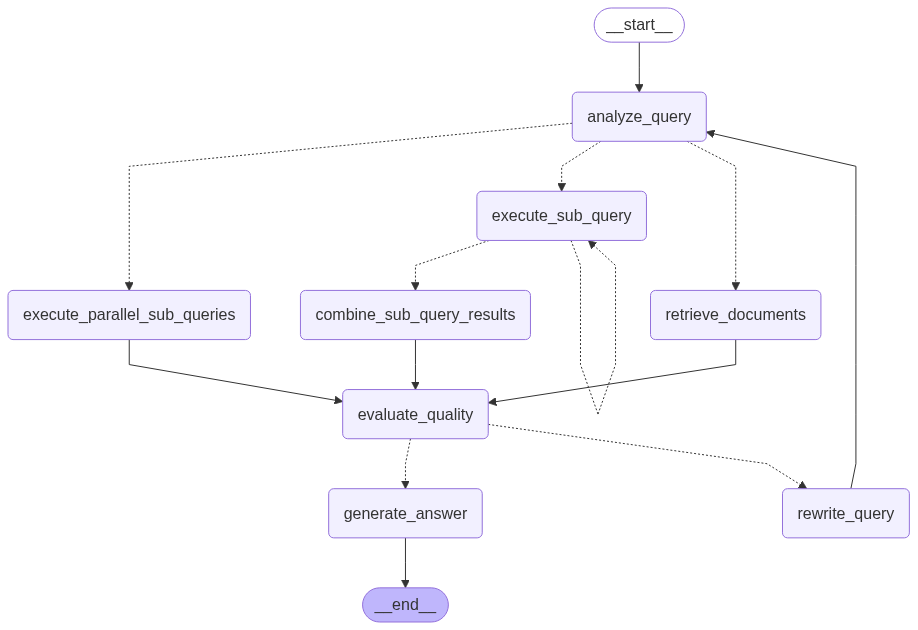

In [15]:
from IPython.display import Image, display

display(Image(adaptive_rag_graph.get_graph().draw_mermaid_png()))

## Test the Adaptive RAG System

Let's test our adaptive system with various types of queries.

In [64]:
def ask_adaptive_rag(query: str):
    """Ask a question to our Adaptive RAG system."""
    print(f"\n{'='*80}")
    print(f"QUERY: {query}")
    print(f"{'='*80}")
    
    # Run the adaptive RAG workflow
    result = adaptive_rag_graph.invoke({"query": query})
    
    print(f"\nFINAL ANSWER (Confidence: {result['confidence'].upper()}):")
    print(f"{result['answer']}")
    print(f"{'='*80}")

# Test with a simple, clear query (no decomposition)
ask_adaptive_rag("Do you have bluetooth headphones and how fast can they be shipped within the US?")


QUERY: Do you have bluetooth headphones and how fast can they be shipped within the US?
Query Analysis:
  Complexity: medium
  Needs Decomposition: True
  Sub-queries: ['Do you have bluetooth headphones?', 'How fast can bluetooth headphones be shipped within the US?']
  Execution Plan: sequential
  Strategy: multi_collection
  Collections: ['catalog', 'faq']
  Reasoning: The query contains two distinct questions: product availability (catalog) and shipping speed (faq). The second question depends on the first, as shipping information is only relevant if the product is available. Therefore, decomposition is needed with a sequential execution plan. Both the catalog and faq collections are required, making this a multi-collection search. The overall complexity is medium, as it spans two domains but is not highly complex.

Executing sub-query 1/2: Do you have bluetooth headphones?


InternalError: Error getting collection: Database error: error returned from database: (code: 14) unable to open database file

In [ ]:
# Test with parallel decomposition query
ask_adaptive_rag("What gaming laptops do you have and what are your return policies?")

In [ ]:
# Test with sequential decomposition query
ask_adaptive_rag("Show me laptops under $1500, then tell me shipping options for the best one")

In [ ]:
# Test with web search query that needs current information
ask_adaptive_rag("Windows 11 blue screen error 0x0000007E - how do I fix this?")

## Test Mixed Queries (Internal + Web Search)

Let's test queries that require both internal collections and web search through decomposition.

In [ ]:
# Test complex query mixing internal collections and web search
ask_adaptive_rag("I need a laptop for programming and want to know how to fix Chrome crashes on latest macOS")

In [ ]:
# Test another mixed query
ask_adaptive_rag("What gaming desktops do you have and how do I fix latest NVIDIA driver issues?")

In [ ]:
# Very vague query
ask_adaptive_rag("I need something fast")

## Interactive Testing

Try your own complex queries to see how the adaptive system handles them.

In [ ]:
# Try your own complex query here!
your_question = "I'm a student who needs a computer setup for programming and gaming, but I'm on a budget and need to know about warranty and support options"
ask_adaptive_rag(your_question)

## Comparison: Evolution of RAG Approaches

Let's compare all three approaches we've built:

### Basic RAG (Notebook 1)
**Approach**: Single collection, fixed retrieval strategy
- **Strengths**: Simple, fast, works for clear single-domain queries
- **Weaknesses**: Context pollution, no domain awareness, fixed strategy, no current information access
- **Best for**: Simple, unambiguous queries in single domain

### Router RAG (Notebook 2)
**Approach**: Intent-based routing to appropriate collection or web search
- **Strengths**: Domain-specific retrieval, eliminates context pollution, good for clear intent, web search for current info
- **Weaknesses**: Single collection limit, no quality assessment, no self-correction, handles only single questions
- **Best for**: Clear domain-specific queries with obvious intent, including current information needs

### Adaptive RAG with Query Decomposition + Web Search (Notebook 3)
**Approach**: Dynamic strategy selection with query decomposition, quality assessment, self-correction, and web search integration
- **Strengths**: 
  - **Query Decomposition**: Breaks complex multi-part questions into manageable sub-queries
  - **Parallel/Sequential Execution**: Optimizes sub-query execution based on dependencies
  - **Multi-collection search** for complex queries including web search
  - **Web Search Integration**: Access to current information for troubleshooting and technical issues
  - **Quality evaluation** of retrieved documents
  - **Query rewriting** for better results (conservative approach)
  - **Self-correction** through iterative improvement
  - **Confidence scoring** for answer reliability
  - **Graceful failure** when no information is found
- **Weaknesses**: More complex, higher latency, more API calls
- **Best for**: Complex, multi-domain, multi-part, or ambiguous queries requiring both internal knowledge and current information

### When to Use Each Approach:

**Basic RAG**: 
- Simple applications with homogeneous data
- When speed is critical and queries are predictable
- Prototype or proof-of-concept development

**Router RAG**: 
- Multi-domain applications with clear, single-question query patterns
- When you need domain expertise and current information access
- Good balance of accuracy and performance for straightforward questions

**Adaptive RAG with Decomposition + Web Search**: 
- Complex applications with diverse, unpredictable, multi-part queries
- When answer quality is more important than speed
- Applications requiring high reliability and self-correction
- Systems handling compound questions like "What products do you have AND what are current software issues?"
- Workflows requiring sequential reasoning and current information access
- Enterprise systems needing both internal knowledge and real-time troubleshooting

### Key Innovations in Adaptive RAG with Decomposition + Web Search:

1. **Query Decomposition Analysis**: Identifies when complex queries should be broken down
2. **Execution Planning**: Determines whether sub-queries should run sequentially or in parallel
3. **Parallel Execution**: Runs independent sub-queries simultaneously for efficiency
4. **Sequential Execution**: Handles dependent sub-queries in proper order
5. **Sub-Query Result Combination**: Intelligently merges results from multiple sub-queries
6. **Multi-Collection Retrieval**: Can search multiple domains simultaneously
7. **Web Search Integration**: Access to current information via Tavily for real-time troubleshooting
8. **Document Quality Grading**: Evaluates relevance of retrieved documents
9. **Conservative Query Rewriting**: Only rewrites when NO relevant docs found, up to 3 attempts
10. **Graceful Failure Handling**: Provides helpful responses even when no information is found
11. **Self-Correction**: Iteratively improves results through feedback loops
12. **Confidence Assessment**: Provides transparency about answer reliability

### Query Decomposition + Web Search Examples:

**Mixed Source Parallel Decomposition**:
- "I need a laptop for programming and want to know how to fix Chrome crashes on latest macOS"
- Breaks into: ["Show me laptops suitable for programming", "How to fix Chrome crashes on latest macOS"]
- Sources: [catalog] + [web_search]

**Internal + Current Information**:
- "What gaming desktops do you have and how do I fix latest NVIDIA driver issues?"
- Breaks into: ["What gaming desktops do you have?", "How to fix latest NVIDIA driver issues?"]
- Sources: [catalog] + [web_search]

**Current Troubleshooting**:
- "Windows 11 blue screen error 0x0000007E - how do I fix this?"
- No decomposition needed, routes to: [web_search]

This represents the most advanced agentic RAG system combining internal knowledge with real-time information access!

## Summary

Congratulations! You've built a sophisticated adaptive RAG system with query decomposition and web search integration that represents the current state-of-the-art in agentic information retrieval.

### What We Built
1. **Query Complexity Analysis**: Automatic assessment of query characteristics and optimal strategy selection
2. **Query Decomposition System**: Intelligent breakdown of complex multi-part queries into manageable sub-queries
3. **Execution Planning**: Dynamic determination of parallel vs sequential execution based on query dependencies
4. **Multi-Collection Retrieval**: Intelligent searching across multiple specialized data sources
5. **Web Search Integration**: Real-time information access via Tavily for current troubleshooting and technical issues
6. **Document Quality Evaluation**: Automated relevance grading with confidence scoring
7. **Conservative Query Rewriting**: Smart rewriting only when no relevant docs found, with graceful failure
8. **Self-Correcting Workflow**: Iterative refinement based on quality feedback
9. **Adaptive Answer Generation**: Context-aware response creation with confidence indicators

### Key Concepts Learned
- **Query Decomposition**: Breaking complex questions into simpler, answerable parts
- **Execution Planning**: Optimizing sub-query execution based on dependencies
- **Parallel vs Sequential Processing**: When to run sub-queries simultaneously vs in order
- **Web Search Integration**: Seamlessly combining internal knowledge with real-time information
- **Adaptive Strategy Selection**: Choosing retrieval approaches based on query characteristics
- **Quality-Driven Workflows**: Using feedback loops to improve results
- **Multi-Source Integration**: Combining information from diverse collections and web search
- **Conservative Rewriting**: Only rewriting when absolutely necessary to avoid over-processing
- **Graceful Failure**: Providing helpful responses even when no information is found
- **Confidence Modeling**: Providing transparency about result reliability

### Technical Achievements
- Complex conditional routing in LangGraph with decomposition and web search pathways
- Structured LLM outputs for reliable decision making and query analysis
- Document diversity maintenance across collections and web results
- Conservative rewriting logic with up to 3 attempts and graceful failure
- Multi-dimensional quality assessment across different source types
- Dynamic workflow adaptation based on query complexity and dependencies
- Seamless integration of real-time web search with internal knowledge bases

### Query Decomposition + Web Search Innovation
The decomposition system with web search handles complex scenarios like:
- **Mixed source questions**: "I need a laptop and want to know about Chrome crashes"
- **Sequential dependencies with current info**: "Find laptops, then tell me about latest driver issues"
- **Independent parallel queries**: "Show me headphones and current Bluetooth problems"
- **Complex reasoning with real-time data**: Breaking down multi-step requests requiring current information

### Real-World Applications
This adaptive RAG approach with decomposition and web search is suitable for:
- **Enterprise Knowledge Management**: Complex internal documentation with real-time troubleshooting
- **Customer Support Platforms**: Multi-domain help systems with access to current solutions
- **Technical Support Systems**: Combining product knowledge with latest troubleshooting information
- **Research Assistants**: Academic or professional research requiring both historical and current data
- **E-commerce Platforms**: Product information combined with current compatibility and issue resolution
- **Educational Systems**: Learning platforms needing both curriculum content and current technical information
- **IT Help Desk Systems**: Internal knowledge combined with latest patches, updates, and solutions

### Performance Benefits
- **Comprehensive Coverage**: Handles compound questions spanning internal and current information
- **Optimized Execution**: Parallel processing where possible, sequential where necessary
- **Higher Accuracy**: Focused sub-queries reduce context pollution while accessing current data
- **Real-time Relevance**: Web search ensures up-to-date information for technical issues
- **Conservative Processing**: Avoids unnecessary rewrites while ensuring quality results
- **Improved User Experience**: Natural handling of complex, multi-part questions with current information
- **Scalable Architecture**: Can handle increasingly complex query patterns with real-time data needs

You've now mastered the complete spectrum of RAG architectures, from basic retrieval to sophisticated adaptive systems with query decomposition and web search integration. These techniques form the foundation for building truly intelligent, responsive AI applications that can handle the complexity and multi-faceted nature of real-world information needs while staying current with the latest information.

The journey from basic RAG to adaptive RAG with decomposition and web search demonstrates the power of agentic AI - systems that don't just follow fixed patterns, but actively analyze, plan, adapt, and improve their own performance while handling complex, multi-part queries and seamlessly integrating both internal knowledge and real-time information from the web!